In [1]:
import numpy as np
import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

In [2]:
#обучать сеть будем на датасете EMNIST (цифры+прописные+строчные английские буквы)
batch_size=32
trans1=transforms.Compose([transforms.ToTensor(),transforms.ToPILImage(),transforms.RandomRotation(20),transforms.ToTensor()])
trans2=transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.EMNIST(root='./data', train=True, 
                                      download=True, split='balanced',transform=trans1)
testset = torchvision.datasets.EMNIST(root='./data', train=False, 
                                      download=True, split='balanced',transform=trans2)


100%|██████████| 561753746/561753746 [00:12<00:00, 43793334.92it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


In [3]:
#с данными разобрались
#самое интересное - собственно нейросетка
import torch.nn as nn
import torch.nn.functional as F 

In [4]:
class ConvNN (nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.cbn1=nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.cbn2=nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cbn3=nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.cbn4=nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(4 * 4 * 64, 256)
        self.bn1=nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256,128)
        self.bn2=nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 47)
        self.dropout=nn.Dropout(0.5)
        
        

    def forward(self, x):
        x=F.relu(self.cbn1(self.conv1(x)))
        x=F.relu(self.cbn2(self.conv2(x)))
        x=self.pool(x)
        x=F.relu(self.cbn3(self.conv3(x)))
        x=F.relu(self.cbn4(self.conv4(x)))
        x=self.pool(x)
        x = x.view(-1, 4 * 4 * 64)
        x=self.dropout(F.relu(self.bn1(self.fc1(x))))
        x=self.dropout(F.relu(self.bn2(self.fc2(x))))
        x=self.fc3(x)
        return x

In [5]:
def train (model,train_files,val_files,batch_size,epochs):
    trainloader = DataLoader(train_files, batch_size=batch_size,shuffle=True, num_workers=2)
    valloader = DataLoader(val_files, batch_size=batch_size,shuffle=False, num_workers=2)
    optimizer=torch.optim.SGD(model.parameters(),lr=1e-2,momentum=0.9,nesterov=True)
    criterion=nn.CrossEntropyLoss()
    #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
    scheduler=torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,base_lr=1e-2,max_lr=7e-2,step_size_up=4000,mode='exp_range',gamma=0.9992)
    history=[]
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f} val_loss: {v_loss:0.4f} val_acc {v_acc:0.4f}"
    for epoch in range(0,epochs):
        running_loss=0.0
        running_corrects=0.0
        processed=0.0
        model.train(True)
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
            processed+=inputs.size(0)
            scheduler.step()
            
        val_loss, val_acc = eval_epoch(model, valloader, criterion)
        #scheduler.step(val_loss)
        train_loss=running_loss/processed
        train_acc=running_corrects/processed
        print(log_template.format(ep=epoch+1,t_loss=train_loss,t_acc=train_acc,v_loss=val_loss,v_acc=val_acc))
        history.append((epoch+1,train_loss,val_loss))   

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed=0
    for inputs, labels in val_loader:        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed += inputs.size(0)
    val_loss = running_loss / processed
    val_acc = running_corrects.double() / processed
    return val_loss, val_acc


In [6]:
#вспомогательная функция для нахождения оптимального learning rate
#вызывается 1 раз
#делается это так: стартуем с маленького lr (например 1e-7)
#заканчиваем на большом (0.1)
#после каждого батча увеличиваем lr
#делаем это до тех пор, пока лосс не начнет расти
#находим минимум (у нас минимальный лосс был достигнут при lr=0.7)
#итоговый lr берем на порядок меньше (т.e. 0.07)
def findlr (model,train_files,batch_size,num_els):
    trainloader = DataLoader(train_files, batch_size=batch_size,shuffle=True, num_workers=2)
    optimizer=torch.optim.SGD(model.parameters(),lr=1e-7,momentum=0.9,nesterov=True)
    
    criterion=nn.CrossEntropyLoss()
    lr=1e-7
    init=1e-7
    maxlr=10
    lr_find_loss=[]
    smooth=0.05
    counter=0
    log_template = "\nEpoch {ep:03d} ninput: {n:05d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        if (counter==0):
            lr_find_loss.append((lr,loss.item()))
        else:
            lr_find_loss.append((lr,smooth*loss.item()+(1-smooth)*lr_find_loss[-1][1]))
        counter+=1
        print(counter,lr_find_loss[-1])
        #увеличиваем lr
        lr=init*np.exp(np.log(maxlr/init)*batch_size/num_els*counter)
        for g in optimizer.param_groups:
            g['lr'] = lr
    return lr_find_loss

In [ ]:
net=ConvNN()
loss=findlr(net,trainset,256,len(trainset.train_data))


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


1 (1e-07, 3.942620277404785)
2 (1.0426919685888784e-07, 3.9451984047889708)
3 (1.0872065413597506e-07, 3.9472324436902997)
4 (1.1336215288731041e-07, 3.950560614138841)
5 (1.1820180635754312e-07, 3.9525261466071004)
6 (1.23248074161708e-07, 3.9573133982367064)
7 (1.285097770724594e-07, 3.9592137443313407)
8 (1.3399611243860064e-07, 3.962790928475552)
9 (1.397166702618612e-07, 3.9637840867865766)
10 (1.4568144996002323e-07, 3.967664546448712)
11 (1.519008778456988e-07, 3.9661413822022955)
12 (1.5838582535131044e-07, 3.9678925110673395)
13 (1.6514762803213216e-07, 3.9702976129538525)
14 (1.7219810538060772e-07, 3.971044838724769)
15 (1.79549581486581e-07, 3.975936481638079)
16 (1.8721490657955239e-07, 3.9763388929954755)
17 (1.9520747949061644e-07, 3.977792481907408)
18 (2.0354127107334396e-07, 3.9815099888163714)
19 (2.1223084862454756e-07, 3.98158025944849)
20 (2.2129140134761773e-07, 3.983219387078177)
21 (2.3073876690293912e-07, 3.983177079604761)
22 (2.4058945909179593e-07, 3.985629

In [ ]:
#зависимость loss от lr
fig=plt.figure()
l=np.array(loss).T
plt.plot(np.log(l[0]),l[1])
plt.xlabel('lr')
plt.ylabel('loss')

In [ ]:
net=ConvNN()
#она довольно долго обучается, но я потом скину график лосса и accuracy
#Train Accuracy и Val Accuracy ~ 90 %
#для этого датасета это хороший результат, поскольку в нем и буквы и цифры, а например 0 очень сложно отличить от О
#history=train(net,trainset,testset,256,30)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
#torch.save(net.state_dict(), "/content/gdrive/My Drive/model_weights.pth")
#загружаем веса обученной модели
net.load_state_dict(torch.load("/content/gdrive/My Drive/model_weights.pth"))

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


<All keys matched successfully>

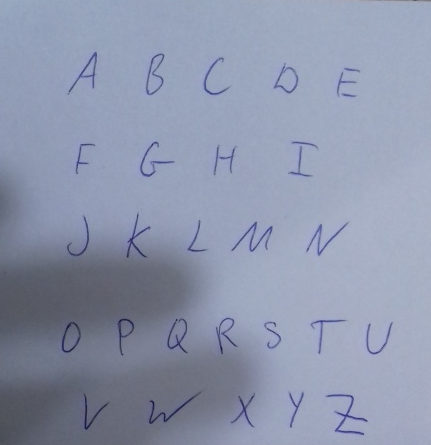

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
#открываем картинку
image = cv2.imread("/content/gdrive/My Drive/test18.png")
cv2_imshow(image)


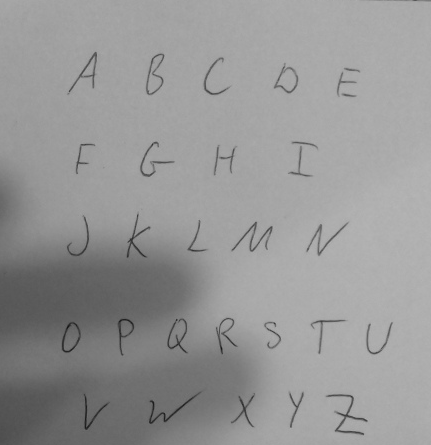

In [ ]:
#переведем в градации серого
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

In [ ]:
gray_img=gray_image/255

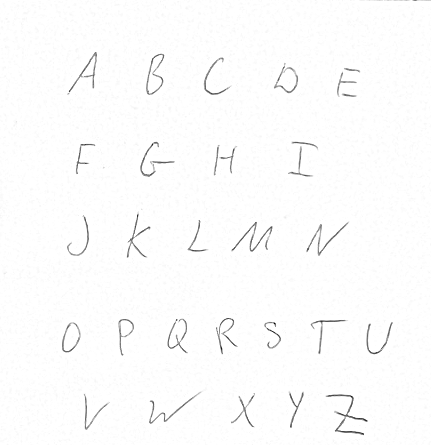

In [ ]:
conv_img=gray_img.copy()

N=9
kernel=np.ones((N,N))/(N*N)
kernel[int(np.floor(N/2))][int(np.floor(N/2))]-=1
cv2.filter2D(src=gray_img,ddepth=-1,dst=conv_img,kernel=kernel,borderType=1)
conv_img=256-conv_img*256/conv_img.max()
cv2_imshow(conv_img)

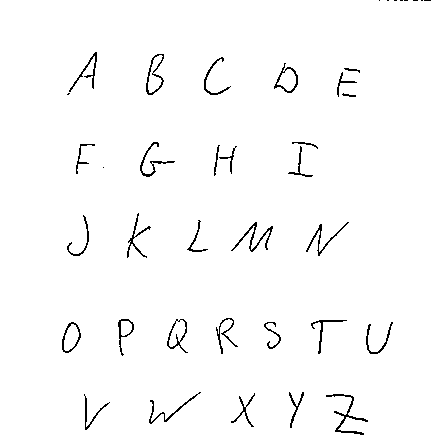

In [ ]:
mean=conv_img.mean()
std=conv_img.std()
ret, threshold_image = cv2.threshold(conv_img, mean-2*std, 255, 0)
cv2_imshow(threshold_image)
threshold_image=threshold_image.astype(np.uint8)

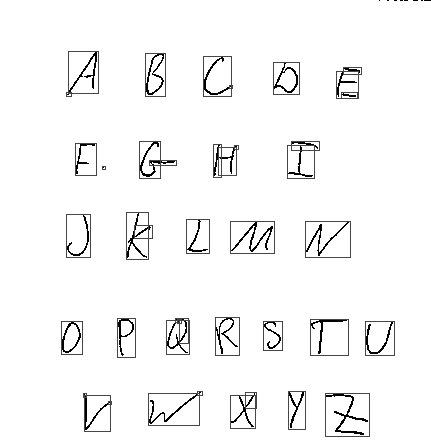

In [ ]:
#ок, теперь попробуем разделить это на буквы.
#используем функцию findContours из библиотеки cv
contours, hierarchy = cv2.findContours(threshold_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
output = threshold_image.copy()
rectangles=[]
for idx, contour in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    # print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
    # hierarchy[i][0]: the index of the next contour of the same level
    # hierarchy[i][1]: the index of the previous contour of the same level
    # hierarchy[i][2]: the index of the first child
    # hierarchy[i][3]: the index of the parent
    if hierarchy[0][idx][3] == 0:
        cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
        rectangles.append([x,y,w,h])   

cv2_imshow(output)      

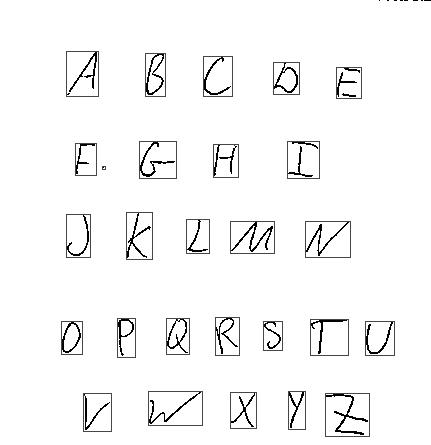

In [ ]:
#Вышло не очень. Попробуем как минимум, объединить пересекающиеся прямоугольники
for i in range (0,len(rectangles)):
    if rectangles[i][2]==0:
        continue
    for j in range (0, len(rectangles)):
        x1=rectangles[i][0]
        x2=rectangles[j][0]
        y1=rectangles[i][1]
        y2=rectangles[j][1]
        w1=rectangles[i][2]
        w2=rectangles[j][2]
        h1=rectangles[i][3]
        h2=rectangles[j][3]
        if (x1>=x2 and x1<=x2+w2) and (y1>=y2 and y1<=y2+h2):
            rectangles[j][2]=0
            rectangles[j][3]=0
            rectangles[i][2]=max(x1+w1,x2+w2)-min(x1,x2)
            rectangles[i][0]=min(x1,x2)
            rectangles[i][1]=min(y1,y2)
            rectangles[i][3]=max(y1+h1,y2+h2)-min(y1,y2)
            continue
        if (x1>=x2 and x1<=x2+w2) and (y2>=y1 and y2<=y1+h1):
            rectangles[j][2]=0
            rectangles[j][3]=0
            rectangles[i][2]=max(x1+w1,x2+w2)-min(x1,x2)
            rectangles[i][0]=min(x1,x2)
            rectangles[i][1]=min(y1,y2)
            rectangles[i][3]=max(y1+h1,y2+h2)-min(y1,y2)
            continue
        if (x2>=x1 and x2<=x1+w1) and (y1>=y2 and y1<=y2+h2):
            rectangles[j][2]=0
            rectangles[j][3]=0
            rectangles[i][2]=max(x1+w1,x2+w2)-min(x1,x2)
            rectangles[i][0]=min(x1,x2)
            rectangles[i][1]=min(y1,y2)
            rectangles[i][3]=max(y1+h1,y2+h2)-min(y1,y2)
            continue
        if (x2>=x1 and x2<=x1+w1) and (y2>=y1 and y2<=y1+h1):
            rectangles[j][2]=0
            rectangles[j][3]=0
            rectangles[i][2]=max(x1+w1,x2+w2)-min(x1,x2)
            rectangles[i][0]=min(x1,x2)
            rectangles[i][1]=min(y1,y2)
            rectangles[i][3]=max(y1+h1,y2+h2)-min(y1,y2)
            continue

output = threshold_image.copy()
for rect in rectangles:
    x=rect[0]
    y=rect[1]
    w=rect[2]
    h=rect[3]
    cv2.rectangle(output, (x,y), (x+w, y+h), (70, 0, 0), 1)
cv2_imshow(output)

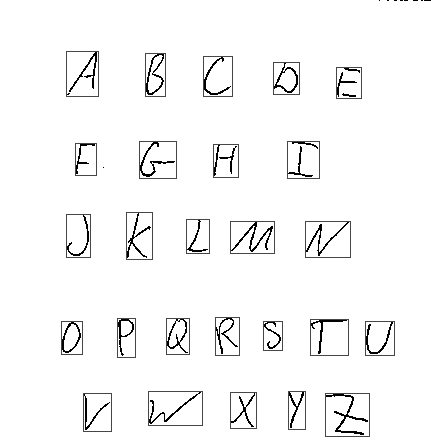

In [ ]:
#к несчастью, в английском языке есть буквы, которые состоят из 2 частей, а конкретно, i и j
#учтем и это
i=0
h_av=0
while (i<len(rectangles)):
    if rectangles[i][2]==0:
          rectangles.pop(i)
    else:
        h_av+=rectangles[i][3]
        i+=1
        
h_av/=len(rectangles)         
for i in range (0,len(rectangles)):
    if rectangles[i][3]<0.7*h_av:
      for j in range(0,len(rectangles)):
          if rectangles[j][2]==0:
              continue
          x1=rectangles[i][0]
          x2=rectangles[j][0]
          y1=rectangles[i][1]
          y2=rectangles[j][1]
          w1=rectangles[i][2]
          w2=rectangles[j][2]
          h1=rectangles[i][3]
          h2=rectangles[j][3]
          if (y1+h1<=y2 and abs(y1+h1-y2)<=2*h1) and (x1>=x2-1.1*w1 and x1<=x2+w2+1.1*w1):
              rectangles[i][2]=max(x1+w1,x2+w2)-min(x1,x2)
              rectangles[i][0]=min(x1,x2)
              rectangles[i][1]=min(y1,y2)
              rectangles[i][3]=max(y1+h1,y2+h2)-min(y1,y2)
              rectangles[j][2]=0
              rectangles[j][3]=0
              break  

i=0
while (i<len(rectangles)):
    if rectangles[i][3]<0.3*h_av:
          rectangles.pop(i)
    else:
        i+=1
output = threshold_image.copy()
for rect in rectangles:
    x=rect[0]
    y=rect[1]
    w=rect[2]
    h=rect[3]
    cv2.rectangle(output, (x,y), (x+w, y+h), (70, 0, 0), 1)
#cv2.rectangle(output, (450,171),(460,181),(70,0,0))
cv2_imshow(output)

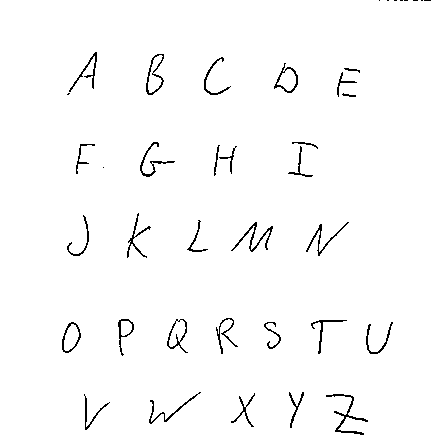

445 431


In [ ]:
def get_letters(pic,contours):
    letters=[]
    cv2_imshow(pic)
    print(len(pic), len(pic[0]))
    w_av=0
    for cont in contours:
        x=cont[0]
        y=cont[1]
        w=cont[2]
        h=cont[3]
        letter_crop=pic[y:y+h,x:x+w]
        size_max=max(w,h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h,0:w] = letter_crop
        elif w < h:
            x_pos = (size_max - w)//2
            letter_square[0:h,x_pos:x_pos + w] = letter_crop
        else:
            letter_square = letter_crop
        w_av+=w
        out_size=28
        # Resize letter to 28x28 and add letter and its X-coordinate
        letter_square = cv2.bitwise_not(letter_square)
        letters.append((x, y,w, h,cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))
    w_av/=len(letters)
    #разбиваем строку на буквы
    letters.sort(key=lambda x: x[1], reverse=False)
    strings=[]
    string=[]
    for i in range(0,len(letters)-1):
        if letters[i][1]+letters[i][3]<letters[i+1][1]:
            string.append(letters[i])
            string.sort(key=lambda x: x[0], reverse=False)
            strings.append(string)
            string=[]
        else:
            string.append(letters[i])
    string.append(letters[-1])
    string.sort(key=lambda x: x[0], reverse=False)
    strings.append(string)
    return strings,w_av
        
strings, w=get_letters(threshold_image,rectangles)
for string in strings:
    for letter in string:
        cv2_imshow(letter[4])


In [ ]:
import PIL
def imgs_to_text(strings,w):
    s=''
    for string in strings:
        for i in range (0,len(string)):
            temp=np.rot90(string[i][4],3)
            temp=np.fliplr(temp)
            #cv2_imshow(temp)
            x = np.array(temp / 255, dtype='float32')
            transform=transforms.Compose([transforms.ToTensor()])
            ttensor=transform(x)
            #распознаем букву
            s+=predict(ttensor,net)
            #проверка на пробел
            if i!=len(string)-1:
                if string[i+1][0]-string[i][0]-string[i][3]>1.2*w:
                    s+=' '
        s+='\n'
    return s
def predict(img,model):
    with torch.no_grad():        
        logits = []    
        model.eval()
        #cv2_imshow((img*255).numpy())
        outputs = model(img.unsqueeze(0))
        logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    map='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
    i=probs.argmax()
    return map[i]


print("Result:",imgs_to_text(strings,w))

Result: ABCDE
FG H I
JKLM N
0PQRSTU
VW XYZ



0
1
2


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


3
4
5
6
7
8
9
A
B
C
D
E
F
G
H
I
J
K
L


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
a
b
d
e
f
g
h
n
q
r
t


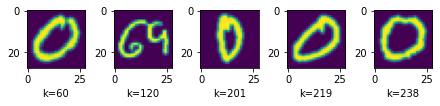

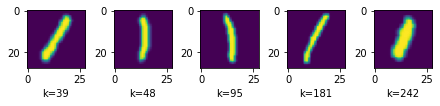

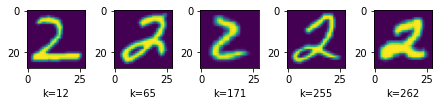

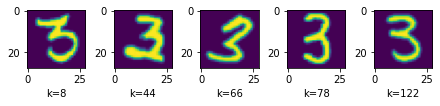

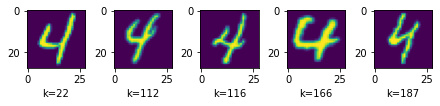

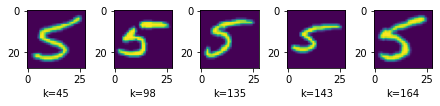

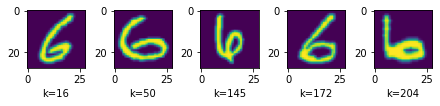

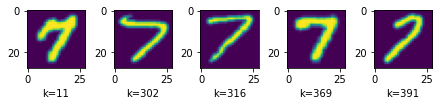

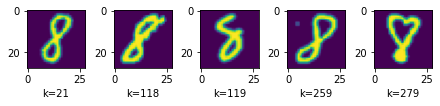

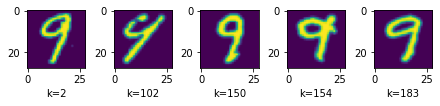

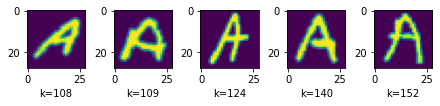

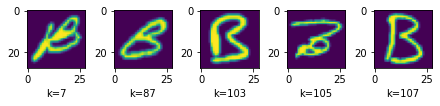

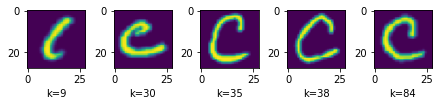

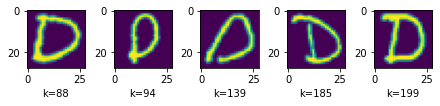

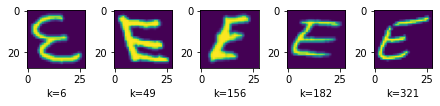

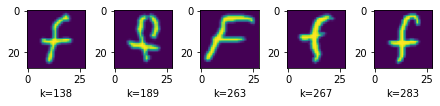

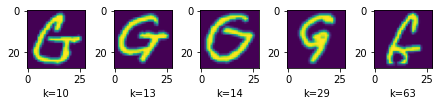

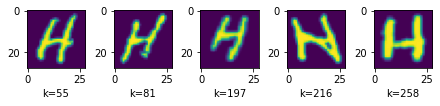

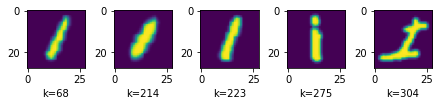

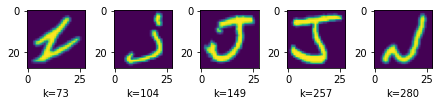

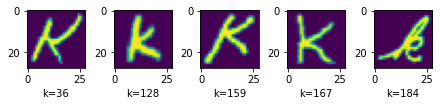

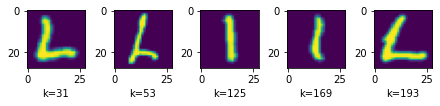

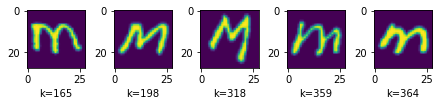

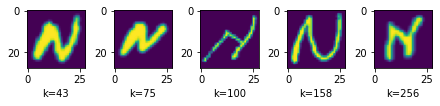

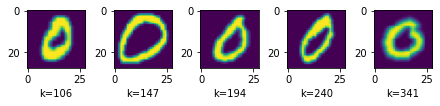

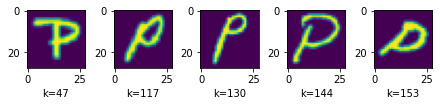

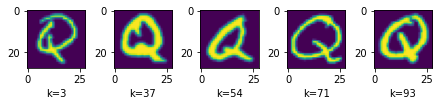

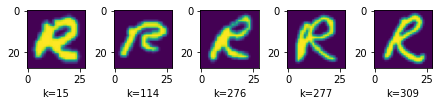

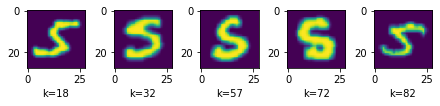

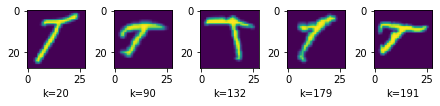

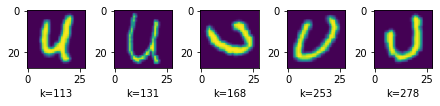

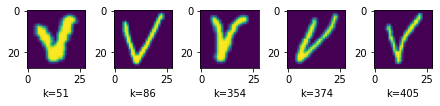

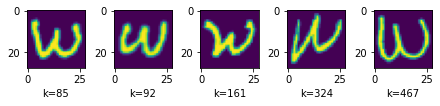

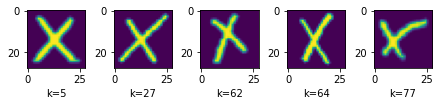

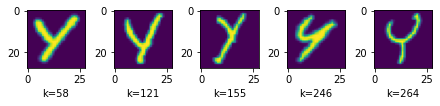

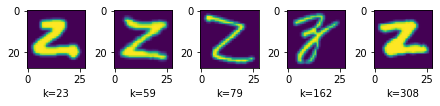

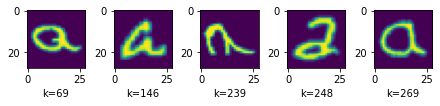

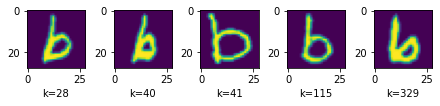

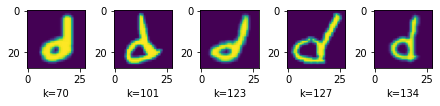

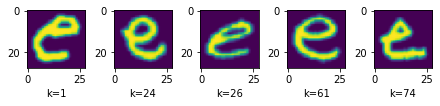

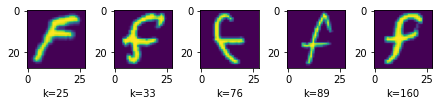

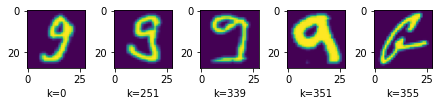

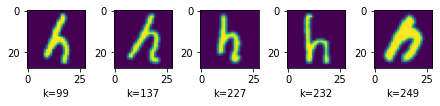

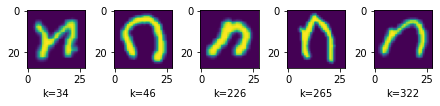

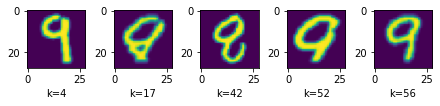

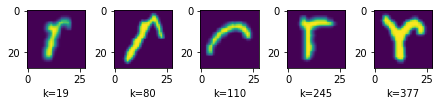

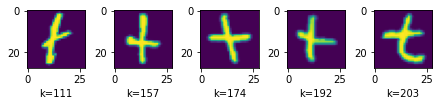

In [ ]:
import matplotlib.gridspec as gridspec
map='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
width=5
for letter_id in range(0,len(map)):
    k = 0
    figa = plt.figure(constrained_layout=True)
    spec=gridspec.GridSpec(ncols=width,nrows=1,figure=figa)
    for i in range(0,width):
        while(testset.test_labels[k].item() != letter_id):
            k+=1
        ax=figa.add_subplot(spec[0,i])
        plt.imshow(np.rot90(np.fliplr(testset.test_data[k])))
        plt.xlabel("k="+str(k))
        k+=1


In [ ]:
a